# IPCC 2019 steady state method
This notebook presents an implementation of the 2019 IPCC steady state Soil Organic Carbon (SOC) estimation methodology (*Tier 2 Steady State Method for Mineral Soils, Chapter 5 Cropland, 2019 Refinement to the 2006 IPCC Guidelines for National Greenhouse Gas Inventories*). The documentation for this methodology is available online [here](https://www.ipcc-nggip.iges.or.jp/public/2019rf/index.html).

In [1]:
import os
import sys
ROOT_DIR = os.getcwd()
if ROOT_DIR + "/src" not in sys.path: sys.path.append(ROOT_DIR + "/src")
import numpy as np
from numpy import array as a
from cfasoc.climate import DemoClimateData, ClimateDataSampled, ClimateDataFromAPI
import cfasoc.ipcc.model as m
import cfasoc.ipcc as ipcc
import cfasoc.builders as bd

## Example 1
Run the SOC model for a number of iterations, using randomly generated carbon input data, and default model parameters.

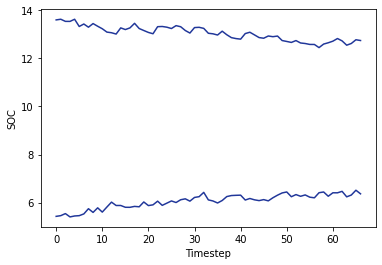

In [2]:
iters = 10
demo_climate_data = DemoClimateData()

temp = bd.repeat_2d_array_as_columns(iters, demo_climate_data.temp)
rain = bd.repeat_2d_array_as_columns(iters, demo_climate_data.rain)
pet = bd.repeat_2d_array_as_columns(iters, demo_climate_data.pet)

t_fac = m.calc_t_fac(t_max=a([45]), temp_i=temp, t_opt=a([33.69]))
irrigated = np.empty(shape=(804,iters), dtype=bool)
irrigated[:] = False
w_fac = m.calc_w_fac(precip_i=rain, pet_i = pet, w_s = a([1]),irrigated=irrigated)
c_input = np.random.rand(67,iters)

res = m.run(t_fac=t_fac, w_fac=w_fac, c_input=c_input)
res.plot_percentile(variable="soc", percentile=(2.5, 97.5))

## Example 2
Run the SOC model for a number of iterations using mostly default model parameters, but with some input data generated using the array builders in *builders.py*. Initiate the model from zero.

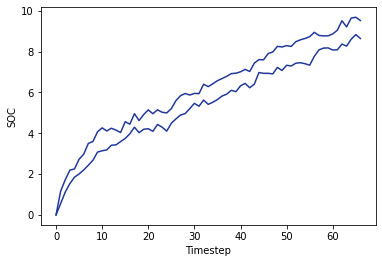

In [3]:
t_fac = m.calc_t_fac(t_max=a([45]), temp_i=temp, t_opt=a([33.69]))
irrigated = np.empty(shape=(804,iters), dtype=bool)
irrigated[:] = False
w_fac = m.calc_w_fac(precip_i=rain, pet_i = pet, w_s = a([1]),irrigated=irrigated)
shape = w_fac.shape

c_input = bd.normal_2d(shape=shape,mu=2, sigma=0.3)
f_1 = bd.truncated_normal_2d(shape=shape, mu=0.378,sigma=0.0719,low=0.01,high=0.8)

res = m.run(t_fac=t_fac, w_fac=w_fac, c_input=c_input, f_1=f_1, active_init=0, slow_init=0,passive_init=0)
res.plot_percentile(variable="soc", percentile=(2.5, 97.5))

## Example 3
Run the model using carbon input generated using *calc_c_input*.

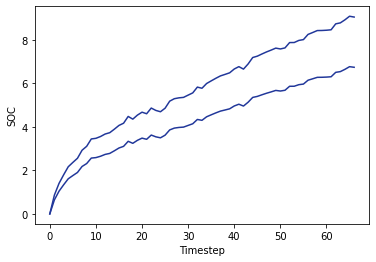

In [4]:
c_input_mu = m.calc_c_input(yield_fresh_t=4000)/1000
c_input_sigma = c_input_mu * 0.1
c_input = bd.normal_1d(shape=shape, mu=c_input_mu,sigma=c_input_sigma)
res = m.run(t_fac=t_fac, w_fac=w_fac, c_input=c_input, active_init=0, slow_init=0,passive_init=0,)
res.plot_percentile(variable="soc", percentile=(2.5, 97.5))

## Example 4
Run the model but with two different periods of carbon input generated from two different distributions, which are then stacked. This approach can be used to model different practices.

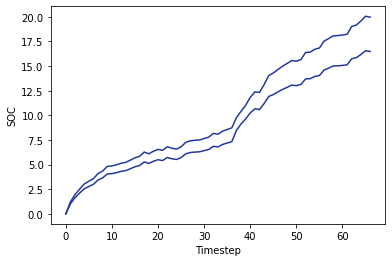

In [5]:
c_input_1 = bd.normal_1d(shape=(37,10),mu=2.5,sigma=0.2)
c_input_2 = bd.normal_1d(shape=(30,10),mu=5,sigma=0.5)
c_input = bd.stack_arrays([c_input_1, c_input_2])
res = m.run(t_fac=t_fac, w_fac=w_fac, c_input=c_input, active_init=0, slow_init=0,passive_init=0,)
res.plot_percentile(variable="soc", percentile=(2.5, 97.5))

## Example 5
Generate a longer climate dataset using *DemoClimateDataSampled*, which uses the data from *DemoClimateData*, forms distributions from the observations, and then samples from the distribitions to produce a longer climate dataset. 

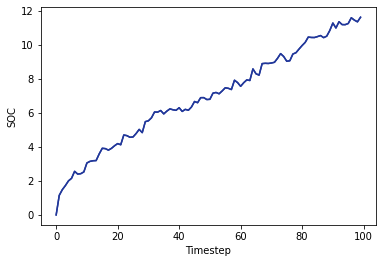

In [6]:
years = 100
iters = 1

demo_climate_data_sampled = ClimateDataSampled(demo_climate_data, years=years, iters=iters)
t_fac = m.calc_t_fac(t_max=a([45]), temp_i=demo_climate_data_sampled.temp, t_opt=a([33.69]))
irrigated = np.empty(shape=(years*12), dtype=bool)
irrigated[:] = False
w_fac = m.calc_w_fac(precip_i=demo_climate_data_sampled.rain, pet_i = demo_climate_data_sampled.pet, w_s = a([1]),irrigated=irrigated)
shape = w_fac.shape

c_input = bd.normal_2d(shape=shape,mu=2, sigma=0.3)
f_1 = bd.truncated_normal_2d(shape=shape, mu=0.378,sigma=0.0719,low=0.01,high=0.8)

res = m.run(t_fac=t_fac, w_fac=w_fac, c_input=c_input, f_1=f_1, active_init=0, slow_init=0,passive_init=0)
res.plot_percentile(variable="soc", percentile=(2.5, 97.5))

## Example 6
*DemoClimateDataSampled* also allows us to generate multiple iterations of climate data.

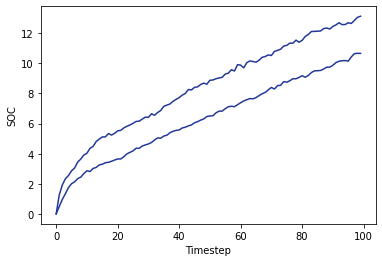

In [7]:
years = 100
iters = 100
demo_climate_data_sampled = ClimateDataSampled(climate_data=demo_climate_data, years=years, iters=iters)
t_fac = m.calc_t_fac(t_max=a([45]), temp_i=demo_climate_data_sampled.temp, t_opt=a([33.69]))
irrigated = np.empty(shape=(years*12, iters), dtype=bool)
irrigated[:] = False
w_fac = m.calc_w_fac(precip_i=demo_climate_data_sampled.rain, pet_i = demo_climate_data_sampled.pet, w_s = a([1]),irrigated=irrigated)
shape = w_fac.shape

c_input = bd.normal_2d(shape=shape,mu=2, sigma=0.3)
f_1 = bd.truncated_normal_2d(shape=shape, mu=0.378,sigma=0.0719,low=0.01,high=0.8)

res = m.run(t_fac=t_fac, w_fac=w_fac, c_input=c_input, f_1=f_1, active_init=0, slow_init=0,passive_init=0)
res.plot_percentile(variable="soc", percentile=(2.5, 97.5))

## Example 7
Run the model for a more realistic scenario based on actual on-farm practices.

| Reference | Years       | Yield (t ha<sup>-1</sup>) | Irrigation | Tillage      |
| --------- | ----------- | ------------------------- | ---------- | ------------ |
| A         | 1970 - 1980 | 2                         | None       | Full-till    |
| B         | 1980 - 1990 | 1.8                       | None       | Full-till    |
| C         | 1990 - 1995 | 1.6                       | None       | Full-till    |
| D         | 1995 - 2000 | 1.6                       | None       | Reduced-till |
| E         | 2000 - 2005 | 1.7                       | None       | Reduced-till |
| F         | 2005 - 2010 | 1.9                       | None       | No-till      |
| G         | 2010 - 2015 | 2.1                       | None       | No-till      |
| H         | 2015 - 2020 | 2.3                       | None       | No-till      | 

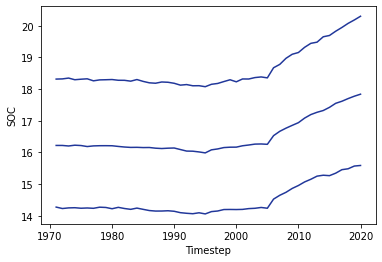

In [8]:
years = 50
iters = 1000

demo_climate_data_sampled = ClimateDataSampled(climate_data=demo_climate_data, years=years, iters=iters)
t_fac = m.calc_t_fac(t_max=a([45]), temp_i=demo_climate_data_sampled.temp, t_opt=a([33.69]))
irrigated = np.empty(shape=(years*12, iters), dtype=bool)
irrigated[:] = False
w_fac = m.calc_w_fac(precip_i=demo_climate_data_sampled.rain, pet_i = demo_climate_data_sampled.pet, w_s = a([1]),irrigated=irrigated)
shape = w_fac.shape

def _build_c_input_array(yield_fresh_t: float, years: int, iters: int) -> np.ndarray:
    c_input = m.calc_c_input(yield_fresh_t=yield_fresh_t)/1000
    c_input_sigma = c_input * 0.1 # To account for variation in c_input
    return bd.normal_2d(shape=(years, iters), mu=c_input, sigma=c_input_sigma)

c_input_A = _build_c_input_array(yield_fresh_t=2000, years=10, iters=iters)
c_input_B = _build_c_input_array(yield_fresh_t=1800, years=10, iters=iters)
c_input_CD = _build_c_input_array(yield_fresh_t=1600, years=5, iters=iters)
c_input_E = _build_c_input_array(yield_fresh_t=1700, years=5, iters=iters)
c_input_F = _build_c_input_array(yield_fresh_t=1900, years=5, iters=iters)
c_input_G = _build_c_input_array(yield_fresh_t=2100, years=5, iters=iters)
c_input_H = _build_c_input_array(yield_fresh_t=2300, years=5, iters=iters)
c_input = bd.stack_arrays([c_input_A, c_input_B, c_input_CD, c_input_CD, c_input_E, c_input_F, c_input_G, c_input_H])

def _build_array(lookup_table: dict, tillage: str, years: int, iters: int) -> np.ndarray:
    mu = lookup_table[tillage]["Value"]
    sigma = lookup_table[tillage]["SD"]
    low = lookup_table[tillage]["Min"]
    high = lookup_table[tillage]["Max"]
    return bd.truncated_normal_2d(shape=(years, iters), mu=mu,sigma=sigma,low=low,high=high)

tillage_lookups = ipcc.TABLE_5_5_A["TillFac"]
tillage_ABC = _build_array(lookup_table=tillage_lookups, tillage="Full-till", years=25,iters=iters)
tillage_DE = _build_array(lookup_table=tillage_lookups, tillage="Reduced-till", years=10,iters=iters)
tillage_FGH = bd.repeat_single(shape=(15,iters), value=tillage_lookups["No-till"]["Value"])
tillage = bd.stack_arrays([tillage_ABC, tillage_DE, tillage_FGH])

timestamps = list(range(1971, 2021, 1))

res = m.run(t_fac=t_fac, w_fac=w_fac, c_input=c_input, till_fac=tillage, timestamps=timestamps)
res.plot_percentile(variable="soc", percentile=(2.5, 50, 97.5))

## Example 8
As example 7 but using climate data from an API which has then been sampled using ClimateDataSampled.

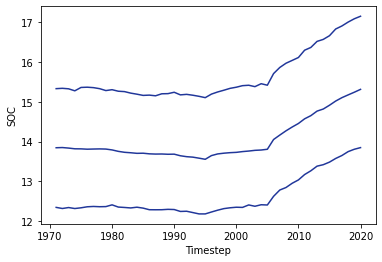

In [9]:
climate_data_from_api = ClimateDataFromAPI(latitude=50, longitude=0)
climate_data_sampled = ClimateDataSampled(climate_data=climate_data_from_api, years=years, iters=iters)

t_fac = m.calc_t_fac(t_max=a([45]), temp_i=climate_data_sampled.temp, t_opt=a([33.69]))
w_fac = m.calc_w_fac(precip_i=climate_data_sampled.rain, pet_i = climate_data_sampled.pet, w_s = a([1]),irrigated=irrigated)

res = m.run(t_fac=t_fac, w_fac=w_fac, c_input=c_input, till_fac=tillage, timestamps=timestamps)
res.plot_percentile(variable="soc", percentile=(2.5, 50, 97.5))